In [1]:
from pprint import pprint
import time
from copy import deepcopy

import pandas as pd
import numpy as np
from dateutil import parser
import matplotlib.pyplot as plt
import seaborn as sns

% matplotlib inline

import requests
from requests_oauthlib import OAuth1

import json
from pymongo import errors
from pymongo import MongoClient


import nltk
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.tokenize import wordpunct_tokenize
from nltk.tag import pos_tag
from nltk.chunk import ne_chunk

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB


### Creating Mongo client, database, and collection

In [2]:
client = MongoClient()
db = client.nyt
articles = db.articles

### Getting articles data for NYT API

The limit on accessing data from the NYT API is 1000 calls per day. I was able to get it up to 5000/day after calling them. There is also a limit on the rate (speed at which you are making the call: Article Search API per second rate limit is 1.

Therefore, the process below took a couple of days

In [3]:
# we are interested in articles we these keywords
condition1 = ('(title:"immigration" OR title:"Immigration" OR title:"Immigrants" OR title:"immigrants") OR '
              '(headline:"immigration" OR headline:"Immigration" OR title:"Immigrants" OR title:"immigrants") OR '
              '(body:"immigration" OR body:"Immigration"  OR title:"Immigrants" OR title:"immigrants")'
             )

In [4]:
# function to extract articles using NYT api starting from teh 1980s

def nyt_articles_extract(page_num, condition, start, end):
    '''
    page_num : page number of the page you want to extract articles from
    condition : the Lucene condition for search as specified on the NYT api page
    return : the 'jsonified' response docs from the api request
    '''
    assert page_num <= 200 # max page shown for every request
    
    response = requests.get("http://api.nytimes.com/svc/search/v2/articlesearch.json?fq=%s," \
                            "&facet_field=day_of_week&page=%d&begin_date=%d&end_date=%d&" \
                            "api-key=<api_key>" % (condition, page_num, start, end))
    try:
        return response.json()['response']['docs']
    except json.JSONDecodeError:
        return None # lets not extract that file then

In [5]:
# function to store extracted NYT articles data into MongoDB

def pymongo_insert(results, database):
    '''
    result: json file of the nyt articles data
    database: the collection in your MongoDB you want to store the data in
    return: None
    '''
    for result in results:

        # create a mongo document by extracting the info I want 
        data={}
        data['_id'] = result['_id']
        
        try:
            data['byline'] = result['byline']
        except KeyError:
            pass # some articles may not have byline, that's alrght
        
        data['document_type'] = result['document_type']
        data['headline'] = result['headline']
        data['pub_date'] = result['pub_date']
        data['snippet'] = result['snippet']
        
        try:
            data['source'] = result['source']
        except KeyError:
            pass # some articles may not have source, that's alrght
        
        data['type_of_material'] = result['type_of_material']
        data['web_url'] = result['web_url']
        
        try:
            data['word_count'] = result['word_count']
        except KeyError:
            pass # some articles may not have word_count, that's alrght

        # add document to the specified mongo database
        try:
            database.insert_one(data)
        except errors.DuplicateKeyError: # skip in case of duplicates
            continue
            
    return None

In [6]:
# combine both the nyt_articles_extract and pymongo_insert function to automate data extraction and storing

def extract_and_store(condition, end, start, database):
    '''
    condition : the Lucene condition for search as specified on the NYT api page
    end : last date of search
    start : start date of search
    database: the collection in your MongoDB you want to store the data in
    end_date
    '''
    for i in range(100, 117):
        docs = nyt_articles_extract(i,condition, start, end)
        
        # catches the result of the exception in nyt_articles_extract
        # don't insert anything
        if docs == None:
            time.sleep(1)
            continue
        else:
            pymongo_insert(docs, database)
            time.sleep(1) # api request rate limit
    return None    

Below is the iterative approach in extracting the data from the NYT api theoretically if I had a large enough request limit that I could do this all in one go. In reality, I had to manually enter a different pair of these start and end dates every day.

In [7]:
# time_frames = [(19800101, 19850101),(19850101, 19900101),
#               (19900101, 19950101),(19950101, 20000101),
#               (20000101, 20050101),(20050101, 20100101),
#               (20100101, 20170101)]

In [8]:
# for time_frame in time_frames:
#    extract_and_store(condition1, start = time_frame[0], end = time_frame[1], datavase = articles)

### Importing these documents from my Mongo DB collection into Pandas

In [165]:
df = pd.DataFrame(list(articles.find())) # original dataframe

### Writing out a file of web urls

I realize that NYT api only returns a snippet of the article and not the full document. Therefore I decided to use external tools to scrape the full articles off of the NYT web page. Therefore, I need the corresponding urls to do so. Here I write to a list all the urls that I obtained from the NYT API

In [10]:
text_file = open("nyt_urls.txt", "a")
for url in df.web_url:
    text_file.write(url)
    text_file.write('\n')

text_file.close()

### Further API work

I end up having to go back to the NYT API to get data from 2010 to 2016 and some of the earlier years since I don't have them in my dataframe. The problem was that the NYT articles API only returned 200 pages of the most recent result as specfied by the end date. Therefore, alot of these cut off dates only have few and some even no sampels at all.

Here I am getting more data for specific years from the NYT api, and writing out the corresponding urls for further web scraping

In [4708]:
# time_frames_add = [(19850101, 19851231),(19910101,19991231),
#                      (19950101,19951231),(19960101,19961231),(20000101,20001231),
#                      (20010101,20011231),(20050101,20051231),(20060101,20061231),
#                      (20070101,20071231),(20100101,20101231),(20110101,20111231),
#                      (20120101,20121231),(20130101,20131231),(20140101,20141231),
#                      (20150101,20151231),(20160101,20161231),]

I am going to create another collection db to store the data from my second try of api query

In [3]:
articles_add = db.articles_add

In [4]:
# for time_frame_add in time_frames_add:
#     extract_and_store(condition1, start = time_frame_add[0], end = time_frame_add[1], database = articles_add)

### Importing these documents from my Mongo DB collection into another Pandas df

- I am also going to write out these additional urls in order to web scrape the entire articles

In [6]:
df_add = pd.DataFrame(list(articles_add.find())) # 'further work' dataframe

In [9]:
text_file = open("nyt_urls_add.txt", "a")
for url in df_add.web_url:
    text_file.write(url)
    text_file.write('\n')

text_file.close()

### Cleaning the `df_articles` and joining it to `df`

 - reformating the http links to https because that is how they originally are in the dataset
 - removing non alphabet characters at the end fo the url strings so as to make it match
 - parse the date out of the pub_date column
 - renaming df 'documet' (mispelled) column
 - create a year column

In [167]:
def to_https(urlList):
    '''
    make 'http' heading of an url into 'https'
    return : a list of modified urls
    '''
    new_urls = []
    for url in urlList:
        if url[4] != 's':
            new_url = url[:4] + 's' + url[4:]
            new_urls.append(new_url)
        else:
            new_urls.append(url)
    return new_urls

def remove_tails(urlList):
    '''
    remove '%0A' characters from the end of the urls
    return : a list of modified urls
    '''
    new_urls = []
    for url in urlList:
        if url[-3:] == '%0A':
            new_urls.append(url[:-3])
        else:
            new_urls.append(url)
    return new_urls

def to_date(datetime_strings):
    '''
    extract the publication date of the article
    date_series : a list of date strings 
    return : a datetime object of the article publication date
    '''
    date_list = []
    for datetime_string in datetime_strings:
        date_string = datetime_string[:10]
        date = parser.parse(date_string)
        date_list.append(date)
    return date_list

def years(dataframe):
    years = []
    for i,row in dataframe.iterrows():
        years.append(row.pub_date.year)
    return years

In [168]:
df_articles = pd.read_csv('nyt_text_all.csv')
df_articles.head(5)

,content,url
0,"LONDON — The British government must stop ""d...",https://www.nytimes.com/reuters/2017/08/03/bus...
1,Federal prosecutors are investigating Kushner...,https://www.nytimes.com/2017/08/03/business/ku...
2,"HELENA, Mont. — A Mexican man who says he wa...",https://www.nytimes.com/aponline/2017/08/03/us...
3,Faced with a new wave of asylum seekers cross...,https://www.nytimes.com/2017/08/03/world/ameri...
4,in the White House: President Trump blamed Co...,https://www.nytimes.com/2017/08/03/briefing/tr...


In [169]:
df_articles.url = to_https(df_articles.url)
df_articles.url = remove_tails(df_articles.url)

In [170]:
df = df.join(df_articles.set_index('url'), on='web_url')

In [171]:
df.pub_date = to_date(df.pub_date)

In [172]:
df['year'] = years(df)

In [173]:
df = df.rename(columns = {'documet_type' : 'document_type'})

### Cleaning the `df_articles_add` and joining it to `df_add` and formatting it

This dataframe is the data retreived under my 'Further API Work' heading

 - reformating the http links to https because that is how they originally are in the dataset
 - removing non alphabet characters at the end fo the url strings so as to make it match
 - parse the date out of the pub_date column
 - create a year column


In [174]:
df_articles_add = pd.read_csv('nyt_text_add.csv', encoding='latin1')
df_articles_add.head()

# As you can see Scrapy(the external scraper) was not able to scrape all the articles since NYT has some
# anti-scraping preventative measures

,url,content
0,https://www.nytimes.com/1985/12/31/us/the-arab...,
1,http://www.nytimes.com/1985/11/28/us/los-angel...,A measure directing Los Angeles city workers ...
2,https://www.nytimes.com/1985/12/30/us/us-repor...,
3,https://www.nytimes.com/1985/12/30/world/terro...,
4,https://www.nytimes.com/1985/12/29/opinion/l-o...,


In [175]:
df_articles_add.url = to_https(df_articles_add.url)
df_articles_add.url = remove_tails(df_articles_add.url)

In [176]:
df_add = df_add.join(df_articles_add.set_index('url'), on='web_url')

In [177]:
df_add.pub_date = to_date(df_add.pub_date)

In [178]:
df_add['year'] = years(df_add)

In [179]:
df_add = df_add.rename(columns = {'documet_type' : 'document_type'})

### Concating the two complete dataframe (`df` and `df_add`)
Now that we have added data of the missing years. We are going to concat the the two dataset so that we have data all the way from 1980 to 2017. There may be some duplicates, so we are going to drop duplicates after appending them together. 

In [180]:
df_full = pd.concat([df_add, df])

In [181]:
df_full.drop_duplicates(subset = '_id', keep='last', inplace = True)

In [182]:
df_full.year.value_counts()
# We have articles all the way from 1981 to 2017

2017    2060
2009    1224
2004     886
1999     805
2003     804
1994     765
1987     740
2008     723
1993     722
1998     667
1984     638
1982     580
1988     548
1989     529
1997     517
1992     515
1983     451
1981     339
2007     260
2014     251
2015     251
2000     244
1995     243
1985     242
2010     242
1990     241
1996     240
2012     240
2013     240
2011     240
2001     240
2016     240
2002     237
2006     236
1991     234
1986     179
2005      81
Name: year, dtype: int64

### Sampling

- Lets look at only observation where we were able to get its associated articles off from NYT.  
- Because some article shave encoded 'nan' as its content, lets drop those obs too

After trying it out on small samples, we tried it on the whole dataset

In [388]:
df_full = df_full[df_full.content != ' '].reset_index()
df_full = df_full.dropna(subset = ['content'])

In [4742]:
df_sample = df_full.sample(15000, random_state= 5555)

In [4743]:
sample_text = list(df_sample.content)

### Some NLP

- Add some more stopwords that I have discovered to be non-informative of the content
- Turn the articles into bag of words throught Tfidf vectorizer


In [4744]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction import text 

from textblob import TextBlob
from nltk.stem.snowball import SnowballStemmer

In [4709]:
stopwords_add = ['yes','sure','thank','that you','let','said', 'new','york', 'united','states', 'state','years','city' ]
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords_add)

In [1121]:
def vectorize_fit_transform(lod ,stopwords ,ngram_range,
                            min_df, max_df, token_pattern = '\\b[a-z][a-z][a-z]+\\b',
                            max_features = 2000, verbose = True):
    '''
    lod = list of documents
    ngram_range = (tuple) The lower and upper boundary of the range of n-values for different
                  n-grams to be extracted. (inclusive of bounds)
    stopwords = list of words that will not be accounted for in bag of words
    min_df = minimum occurence frequency of word in order to be considered
    max_df = maximum occurence frequency above which will not be considered
    verbose = prints feature_names if True
    
    return : (tuple) the vectorizer instance and the bag of words
    '''
    vectorizer = TfidfVectorizer(ngram_range = ngram_range, stop_words = stop_words,
                             min_df= min_df, max_df = max_df, token_pattern= token_pattern,
                             max_features = max_features)
    
    # call `fit` to build the vocabulary
    vectorizer.fit(lod)
    
    # finally, call `transform` to convert text to a bag of words
    x = vectorizer.transform(lod)
    
    if verbose == True:
        # then, use `get_feature_names` to return the tokens
        print(vectorizer.get_feature_names())
        
    return vectorizer, x
    
    

In [4717]:
vec_all, x_all = vectorize_fit_transform(df_full.content, stopwords=stop_words,ngram_range=(1,2),min_df=2,max_df=1800, verbose=True)

['abandoned', 'ability', 'aboard', 'abortion', 'abroad', 'abuse', 'accept', 'accepted', 'access', 'account', 'accounts', 'accused', 'acknowledged', 'acting', 'actions', 'active', 'activities', 'activity', 'acts', 'actually', 'add', 'adding', 'addition', 'additional', 'address', 'administration officials', 'admission', 'admitted', 'adopted', 'adults', 'advance', 'advantage', 'advertising', 'advice', 'adviser', 'advisers', 'advocacy', 'advocates', 'affairs', 'affect', 'affected', 'afford', 'afghanistan', 'afraid', 'africa', 'african', 'afternoon', 'age', 'agencies', 'agenda', 'agent', 'agents', 'agree', 'agreed', 'agreement', 'ahead', 'aid', 'aide', 'aides', 'aids', 'aimed', 'air', 'airlines', 'airport', 'airports', 'alan', 'alien', 'alliance', 'allies', 'allow', 'allowing', 'allows', 'alternative', 'ambassador', 'amendment', 'american citizens', 'american officials', 'amid', 'amnesty', 'analysis', 'analysts', 'angeles', 'angry', 'announcement', 'annual', 'answer', 'apart', 'apartment', 

In [4722]:
X = pd.DataFrame(x_all.toarray(),index = df_full.headline, columns=vec_all.get_feature_names())
X.head(3)

,abandoned,ability,aboard,abortion,abroad,abuse,accept,accepted,access,account,...,writes,writing,written,wrong,wrote,www,yesterday,yorkers,younger,youth
headline,,,,,,,,,,,,,,,,,,,,,
{'main': 'The Arab-American Counts His Stereotypes'},0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.025494,0.0,0.047352,0.0,0.0,0.0,0.0,0.0
{'main': 'U.S. Reports Rise in Attacks On Its Border Patrol Agents'},0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
"{'main': 'TERROR IN 1985: BRUTAL ATTACKS, TOUGH RESPONSE'}",0.0,0.0,0.0,0.0,0.041066,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


### PCA
Since we have high dimensionality we should probably run some PCA to get out the most important components that capture the most variation in our data. 

In [529]:
from sklearn.decomposition import PCA

In [4750]:
pca = PCA(n_components=4,random_state=5555,)
X_pca = pca.fit_transform(X)

In [4752]:
# Check what fraction of the variance is retained
print(pca.explained_variance_ratio_)
print(pca.explained_variance_ratio_.sum())

# PCA principle components doesn't seem to return us good alternative cooridnates that capture the variance

[ 0.01138989  0.00965995  0.00819822  0.0079046 ]
0.0371526572297


### K Means
we will first try to run some K means to see if the algorithm will return any sort of meaningful cluster so that we can say that they are about similar things

In [4753]:
from sklearn.cluster import KMeans

In [4754]:
def inertia_curve(X, k_start, k_final):
    '''
    '''
    k = []
    inertia = []
    for i in range(k_start, k_final + 1):
        km = KMeans(n_clusters=i, random_state=5555, max_iter=1000,)
        fit = km.fit(X)
        k.append(i)
        inertia.append(fit.inertia_)
    inertia_plot, fig = plt.subplots(figsize = (8,5))
    plt.plot(k, inertia)
    plt.title('Inertia Curve', size = 15)
    plt.xlabel('K', size = 12)
    plt.ylabel('Inertia', size = 12)

In [4755]:
def k_mean_labelize(X, num_cluster):
    '''
    X : dataframe
    return cluster label for each of the obs in X using Kmeans
    '''
    km = KMeans(n_clusters=num_cluster, random_state=5555, max_iter=1000,)
    km.fit_transform(X)
    return km.labels_

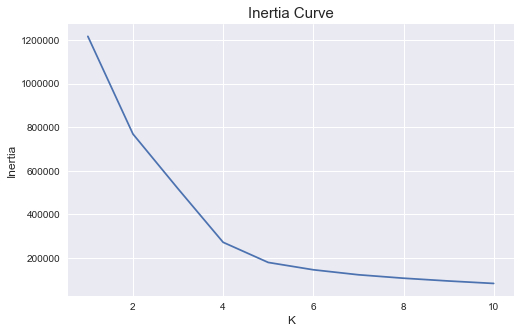

In [4726]:
inertia_curve(X_pca, 1, 10)

In [4756]:
labels = list(zip(range(len(X_pca)),k_mean_labelize(X_pca, 4)))

In [4758]:
pd.Series([label[1] for label in labels]).value_counts()

0    7862
3    5098
2    2019
1     664
dtype: int64

In [4759]:
zero = [i for i,cluster in labels if cluster == 0]
one = [i for i,cluster in labels if cluster == 1]
two = [i for i,cluster in labels if cluster == 2]
three = [i for i,cluster in labels if cluster == 3]

In [4765]:
pprint(list(df_sample.loc[zero].headline[:10]))
print("\n")
pprint(list(df_sample.loc[one].headline[:10]))
print("\n")
pprint(list(df_sample.loc[two].headline[:10]))
print("\n")
pprint(list(df_sample.loc[three].headline[:10]))

[{'main': 'The Arab-American Counts His Stereotypes'},
 {'main': 'TERROR IN 1985: BRUTAL ATTACKS, TOUGH RESPONSE'},
 {'main': "TURIN'S ELEGANT PIAZZAS AND PALAZZOS"},
 {'main': 'BREAKING THEIR SILENCE'},
 {'main': 'AUSTRIA WILL TRY 2 GUNMEN FOR MURDER'},
 {'main': 'REAGANS TO SPEND HOLIDAY IN CAPITAL'},
 {'main': '19th-Century Support for Thesis of Palestine-Depopulation Book'},
 {'main': 'THE UNTHINKABLE WAS UNPRINTABLE'},
 {'main': 'IN SHORT: NONFICTION'},
 {'main': "FRANCE'S BITTER BRAND OF ETHNIC POLITICS"}]


[{'main': '5 HAITIAN STOWAWAYS DISAPPEAR IN A DISPUTE'},
 {'kicker': 'THE WORLD', 'main': 'MORE CUBANS ARE UNWELCOME'},
 {'main': 'REAGAN CURBS ENTRY OF CUBAN OFFICALS'},
 {'main': 'CUBAN REFUGEES ADAPT TO LIFE IN U.S.'},
 {'main': '100 HAITIANS ARE FEARED DROWNED BY SMUGGLERS'},
 {'main': "U.S. 'Ready' to Reopen Cuba Immigration Pact"},
 {'main': 'Miami Journal; The Big Uproar Over Little Havana'},
 {'kicker': 'Abroad at Home', 'main': 'The Rest Is Silence'},
 {'kicker': 'PO

#### This is perhaps a very rough orgranization of topics

cluster 0 has to do with attack, violence, and ethinicity  
cluster 1 has to do with Central America: places such as Cuba, Haiti  
cluster 2 has to with Hispanics, and law regarding immigration  
cluster 3 has to with refuggees  

### NMF

I think we can do much better, so we are goign to try using NMF and see if we can come up with better topics segementations

In [532]:
from sklearn.decomposition import NMF
from sklearn.preprocessing import Normalizer

In [3046]:
def nmf_model(corpus, vectorizer, topics_num, num_topic_words,
              topic_component = False, doc_topic_distr = False):
    '''
    corpus : the bag of words
    vectorizer : a vectorizer instance (from CountVectorizer) 
    topics_num : number of topics to model
    num_topic_words : number of topic words to display
    topic_component : (boolean) If True return model component as well
    doc_topic_distr : (boolean) If True return the distibution of topics for all documents
    '''
    
    model = NMF(topics_num, random_state=5555,)
    dtm_nmf = model.fit_transform(corpus)
    dtm_nmf = Normalizer(copy=False).fit_transform(dtm_nmf)
    
    words = vectorizer.get_feature_names()
    
    topic_words = []
    for component in model.components_:
        a = sorted([(v,i) for i, v in enumerate(component)], reverse = True)[0:num_topic_words]
        topic_words.append([words[e[1]] for e in a])
    
    if topic_component and doc_topic_distr:
        return model.components_, dtm_nmf.round(2), topic_words
    elif topic_component:
        return model.components_, topic_words
    elif doc_topic_distr:
        return dtm_nmf.round(2), topic_words
    else:
        return topic_words
    

In [4771]:
topics, doc, words = nmf_model(x_all, vec_all,topics_num=10, num_topic_words=10, doc_topic_distr=True, topic_component=True)

In [4772]:
pd.Series(k_mean_labelize(pd.DataFrame(doc), 7)).value_counts()

3    3933
1    2538
4    2461
0    2341
2    1884
5    1586
6     900
dtype: int64

### Adopting NMF as main topic modeling approach

I have decided to use NMF to condut topic modeling because it gives me rather discernable keyword groups that I can further use to relegate topics and do further topic modelings with that specific subgroup.

For now, I am going to topic model through on year by year basis. I am interested in seeing whether we can observe the birth and demuse of certain topics within immigration through time.

This may theroretically not make any sense because all subtopics are in one way related with one another. But, let's just see what we can get out of it

In [4901]:
stopwords_add = ['yes','sure','thank','that you','let','said', 'new','york',
                 'united','states', 'state','year','years','city','percent', 'time',
                 'immigrants','immigration','like','nyt','news']
stop_words = text.ENGLISH_STOP_WORDS.union(stopwords_add)

In [4902]:
def create_frames(range_,step,num_frames):
    '''
    range_ : list of number (years)
    step : time frame of which every dataframe encompass
    num_frames : number of frames to create
    return :  alist of dataframes
    '''
    assert step > 0
    frames = num_frames*[np.NaN]
    for i in range(len(frames)):
        start = range_[i]
        end = start + step - 1
    
        frames[i] = df_full[(df_full.year >= start) & (df_full.year <= end)]
    
    return frames

In [3018]:
frame_names = list(map(lambda x : 'df_' + str(x), range(1981,2018,1)))
frames = create_frames(range(1981,2018,1), step = 1, num_frames=len(frame_names))

In [3406]:
# turn each frame_names into a variable that holds the correspnding dataframe of the time period
for i in range(len(frame_names)):
    foo = frame_names[i]
    exec(foo + " = frames[i]")

### Creating a list topics words for each topic in a time period



In [3020]:
from collections import defaultdict

In [4520]:
def topicwords_labels_create(frame_name, topic_num = 7, num_topic_words = 8):
    '''
    Create keywords for every topic in the document list
    as well as labels for every document in the document list.
    
    frame_name : (string) name of the dataframe
    return : (tuple) topic distribution per document, keywords associated with the topic
    '''
    # TF-IDF vectorizing here
    content = eval(frame_name).content
    vec, x = vectorize_fit_transform(content, stopwords, ngram_range=(1,2),
                                     min_df= 2, max_df= 1600,
                                     max_features=2000, verbose= False)
    # nmf here
    doc_distribution, words = nmf_model(corpus=x, vectorizer=vec, topics_num=topic_num,
                                        num_topic_words=num_topic_words, doc_topic_distr=True)
    labels = [list(topic).index(max(topic)) for topic in doc_distribution]
    
    return labels, words
        

In [4521]:
# creating 37 (1981 - 2017) sets of labels and topic words

topics_words_series = []
labels_series = []

for i in range(len(frame_names)):
    doc_distribution, words = topicwords_labels_create(frame_names[i])
    topics_words_series.append(words)
    labels_series.append(doc_distribution)

In [4777]:
len(df_full)

15643

### Matching similar topics across time with each other

- matching for similar topics across time by comparing the keywords of a topic in a time period with that of the past
- the simiarity matching method will be jaccard similarity score

**Note**:  
In reality, a topic can never disapear completely among society... (perhaps more philosphical discussion on that)
so even if a topic has a relative frequency of 0 in a period,we're just going to give it 2 for continuity and graphical visualization purposes

In [4601]:
def word_list_stemmer(low, stemmer = 'porter'):
    '''
    stem every word in a list
    
    low : list of words
    stemmer : the stemmer to implement, if left blank, implement PorterStemmer
    
    return :  a list of stemmed words
    '''
    low_stemmed = []
    if stemmer == 'snowball':
        for word in low:
            stemmed = SnowballStemmer('english').stem(word)
            low_stemmed.append(stemmed)
    else:
        for word in low:
            stemmed = PorterStemmer().stem(word)
            low_stemmed.append(stemmed)
    return low_stemmed


In [4602]:
def find_most_similar(current_topic, all_previous_topics):
    '''
    compare list of words with another list of words using jaccard similarity score
    
    current_topic : list of words to compare similarities to 
    all_previous_topics : list of list of list of words to which the main_list is 
                          going to calculate the jaccard similarity with. Basically 
                          all topics since the for all the years since 1981
                  
    return : (tuple) the highest jaccard similarity score, 
             the index in other_lists that scored the highest with main_list
    '''
    best_jac_score = 0.0
    most_similar_index = 0
    
    for i in range(len(all_previous_topics)):
        for j in range(len(all_previous_topics[i])):
            
            score = (len((set(current_topic) & set(all_previous_topics[i][j]))) /
            len(set(current_topic) | set(all_previous_topics[i][j])))

            if score > best_jac_score:
                best_jac_score = score
                most_similar_index = j
        
            
    return best_jac_score, most_similar_index
    

In [4680]:
def create_topic_time_series(lolot, lolol):
    '''
    store the count of each topic labels in time with previous similar topics labels in a dictionary
    similarity is caluclated using jaccard similarity score in python
    
    lolot : list of list of topics, 2 nested lists within a list
    lolol : list of list of labels, 2 nested lists within a list
    
    return : dictionary, key is topic numbering labels, value is a list label counts for each time period
    '''
    
    topic_time_series = defaultdict(list)
    words_time_series = []
    stemmed_lolot = [[list(set(word_list_stemmer(lolot[i][j]))) for j in range(len(lolot[i]))] 
                                                                for i in range(len(lolot))]
    
    # store the first set of topics (1981) in dictionary first as similarity benchmark for succeeding time periods
    for i in range(len(lolot[0])):
        label_count = lolol[0].count(i)
        topic_time_series[i] = [label_count]
        
    # 'i' is index for the year
    for i in range(1,len(stemmed_lolot)):
        
        # a new current topic list accounts for new topics that differs from previous years topic list
        new_current = [[] for i in range(len(stemmed_lolot[i-1]))]
        
        # 'j' is index for the topics
        for j in range(len(stemmed_lolot[i])):
            
            current_topic = stemmed_lolot[i][j]
            if i-5 < 0:
                all_previous_topics = stemmed_lolot[:i]
            else:
                all_previous_topics = stemmed_lolot[i-5:i]
            best_score, most_similar_index = find_most_similar(current_topic, all_previous_topics)
            
            label_count = lolol[i].count(j)
            
            
            
            # if best_score == 0, not similar to any topic, new topic perhaps
            if best_score == 0:
                
                # create a new key for the topic in the dictionary
                number_of_keys = len(topic_time_series)
                years_ahead = i*[2]
                years_ahead.extend([label_count])
                topic_time_series[number_of_keys] = years_ahead
                
                # add new topic to end of new_current
                new_current.append(stemmed_lolot[i][j])
                
            # in the case there are >1 topics in this time period similar to the same topic in the previous year
            if len(topic_time_series[most_similar_index]) > i:
                topic_time_series[most_similar_index][-1] += label_count
                
                # expand the designated topic list in new_current with more words
                new_current[most_similar_index].extend([" "])
                new_current[most_similar_index].extend(stemmed_lolot[i][j])
                
            else:
                topic_time_series[most_similar_index].append(label_count)
                
                # place current topic at the index location identical to the previous year's topic
                new_current[most_similar_index] = stemmed_lolot[i][j]
        
        
        
        # un-matched topics in previous year mean no news regarding them this year
        for k in range(len(topic_time_series.values())):
            if topic_time_series[k] is None:
                topic_time_series[k] = [2]
            elif len(topic_time_series[k]) < i+1:
                topic_time_series[k].append(2)
                    
        # for 0s in new_current due to appending topics to the end of the list, 
        # fill them in with previous year topic
        for k in range(len(new_current)):
            if new_current[k] == []:
                new_current[k] = stemmed_lolot[i-1][k]
        
        # update current year's topic list
        stemmed_lolot[i] = new_current
        words_time_series.append(new_current)
            
                
    return topic_time_series, words_time_series


In [4681]:
topic_shifts, word_shifts = create_topic_time_series(topics_words_series, labels_series)

### Change absolute label counts into relative frequency

Now that we have the absolute count of a topic in a time period, we want to change that to a relative frequeuncy with respect to all the other topics that is seen during that particular year to assess how "important" this topic is

In [4684]:
def relativize(topic_shifts_dict):
    '''
    convert the absolute count of each topic in each period to the relative frequency of that period
    topic_shifts_dict : (dict) key is topic number, value is list of occurenc of a topic from 1981 - 2017
    
    return : (dict) the reltive frequency across topics
    '''
    
    topic_shifts_rel = deepcopy(topic_shifts_dict)
    for i in range(37):
        denominator = sum([topic_shifts_dict[j][i] for j in range(len(topic_shifts_dict))])
        for j in range(len(topic_shifts_dict)):
            topic_shifts_rel[j][i] = 100 * topic_shifts_dict[j][i] / denominator
            
        
    
    return topic_shifts_rel

In [ ]:
topic_shifts_rel = relativize(topic_shifts)

In [4687]:
topic_shifts_rel

defaultdict(list,
            {0: [12.464589235127479,
              22.091062394603711,
              30.470347648261757,
              35.356600910470412,
              19.272727272727273,
              44.0,
              16.600790513833992,
              31.802120141342755,
              17.926186291739896,
              26.923076923076923,
              0.80000000000000004,
              16.287878787878789,
              31.951219512195124,
              0.25510204081632654,
              0.77220077220077221,
              0.77519379844961245,
              0.37313432835820898,
              0.29368575624082233,
              0.24271844660194175,
              0.77821011673151752,
              10.954063604240282,
              0.78431372549019607,
              0.24390243902439024,
              0.28328611898016998,
              3.0303030303030303,
              4.4534412955465585,
              0.72202166064981954,
              0.27359781121751026,
              2.085222121486

In [4874]:
word_shifts[35][3]

['republican', 'hous', 'white', 'democrat', 'trump', 'white hous', 'presid']

In [4877]:
examine = []
num = 2 # topic num, ie. 2
for year in word_shifts:
        try:
            examine.extend(set(year[num]))
        except IndexError: # Some year may have more topics
            pass # that's fine
examine

['women',
 'million',
 'children',
 'american',
 'america',
 'peopl',
 'vietnam',
 'popul',
 'govern',
 'world',
 'american',
 'life',
 'jewish',
 'old',
 'peopl',
 'israel',
 'park',
 'offici',
 ' ',
 'island',
 'govern',
 'million',
 'statue liberti',
 'children',
 'elli',
 'american',
 'jewish',
 'statu',
 'peopl',
 'liberti',
 'countri',
 'jew',
 'ellis island',
 'island',
 ' ',
 'arab',
 'world',
 'statue liberti',
 'french',
 'pen',
 'american',
 'franc',
 'nation',
 'elli',
 'miss',
 'polic',
 'statu',
 'liberti',
 'ellis island',
 'student',
 'miss lara',
 'colombian',
 'colombia',
 ' ',
 'journalist',
 'chines',
 'lara',
 'asian',
 'american',
 'miss',
 'univers',
 'jewish',
 'abram',
 'patricia lara',
 'peopl',
 'jew',
 'popul',
 'mexico',
 'worker',
 'american',
 'border',
 'peopl',
 'work',
 'mexican',
 'popul',
 'prime minist',
 'chines',
 ' ',
 'mitterrand',
 'hispan',
 'prime',
 'children',
 'pen',
 'french',
 'american',
 'franc',
 'famili',
 'peopl',
 'minist',
 'chira

### Topic Names

This is one of the more difficult and subjective part of the project. 
In order to decide on what the topics were, I had to look into the keywords returned by the `create_topic_time_series` function. I wrote a for loop to inspect the unique words returned by that topic in all 37 years.

I was able to roughly extract the main theme that was present in each of these categories grouped by the function through time. However, it is important to undertand that no two topics are mutually exclusive and that often times a topic may bleed into another in a given year and through time. 

Inspection code:

```python
examine = []
num = 2 # topic num, ie. 2
for year in word_shifts:
        try:
            examine.extend(set(year[num]))
        except IndexError: # Some year may have more topics
            pass # that's fine
print(examine)
```

After topics has been decided I exported the full dataframe into a csv file for D3 visualization later

In [4694]:
topics = ['Boundary, border','Asylum, detainment, police','Immigrant life, education','Politics, party, candidates','Terrorist attacks, security',
         'Europe, EU Politics, Jewish','NY, Central America, East Asia','India',
         'Business, union, outsourcing','Legality',"Social, health, tax policies",
         'Middle East, taliban','Random','News source']



In [4696]:
df_topicDistr = pd.DataFrame(topic_shifts_rel,)
df_topicDistr.columns = topics
year = df_topicDistr.index+1981
df_topicDistr.insert(0,column='year',value=year)
df_topicDistr.head()

,year,"Boundary, border","Asylum, detainment, police","Immigrant life, education","Politics, party, candidates","Terrorist attacks, security","Europe, EU Politics, Jewish","NY, Central America, East Asia",India,"Business, union, outsourcing",Legality,"Social, health, tax policies","Middle East, taliban",Random,News source
0,1981,12.464589,11.331445,37.677054,10.481586,8.781870,7.648725,7.648725,0.566572,0.566572,0.566572,0.566572,0.566572,0.566572,0.566572
1,1982,22.091062,10.286678,23.102867,15.345700,0.337268,14.333895,12.141653,0.337268,0.337268,0.337268,0.337268,0.337268,0.337268,0.337268
2,1983,30.470348,0.408998,33.742331,11.656442,0.408998,0.408998,16.359918,4.089980,0.408998,0.408998,0.408998,0.408998,0.408998,0.408998
3,1984,35.356601,0.303490,41.426404,19.878604,0.303490,0.303490,0.303490,0.303490,0.303490,0.303490,0.303490,0.303490,0.303490,0.303490
4,1985,19.272727,0.727273,32.363636,17.090909,0.727273,10.181818,0.727273,8.363636,6.909091,0.727273,0.727273,0.727273,0.727273,0.727273


In [4697]:
df_topicDistr.to_csv('nyt_topic_distr.csv', index = False)

## NMF every 5 year intervals

In addition to running NMF on articles every single year, I also decided to, just for EDA purposes, to explore it on the basis of every 5 years. Perhaps changes in topics would be more detectable on a 5 year basis.

### Articles published from 1981 - 1985

In [1464]:
vec_8185, x_8185 = vectorize_fit_transform(df_8185.content, stopwords, ngram_range=(1,2),
                                           min_df= 2, max_df= 1600,
                                           max_features=2000, verbose= False)

In [4707]:
nmf_model(corpus=x_8185, vectorizer=vec_8185, topics_num=10, num_topic_words=5)

[['people', 'american', 'children', 'world', 'old'],
 ['aliens', 'illegal', 'illegal aliens', 'simpson', 'employers'],
 ['haitians', 'haitian', 'detention', 'haiti', 'refugees'],
 ['house', 'congress', 'senate', 'reagan', 'president'],
 ['court', 'judge', 'federal', 'justice', 'case'],
 ['refugees', 'cuba', 'cuban', 'cubans', 'castro'],
 ['jewish', 'israel', 'jews', 'soviet', 'israeli'],
 ['island', 'ellis', 'ellis island', 'statue', 'liberty'],
 ['asylum', 'ship', 'service', 'political asylum', 'soviet'],
 ['jackson', 'hispanic', 'mondale', 'democratic', 'party']]

### Articles published from 1986 - 1990

In [1137]:
vec_8690, x_8690 = vectorize_fit_transform(df_8690.content, stopwords, (1,2), min_df= 2, max_df= 2000,
                                           max_features=1500, verbose= False)

In [4706]:
nmf_model(corpus=x_8690, vectorizer=vec_8690, topics_num=10, num_topic_words=5)

[['people', 'children', 'island', 'life', 'family'],
 ['aliens', 'illegal', 'illegal aliens', 'amnesty', 'law'],
 ['soviet', 'soviet union', 'union', 'moscow', 'soviet jews'],
 ['asylum', 'refugees', 'refugee', 'political asylum', 'political'],
 ['president', 'house', 'reagan', 'party', 'military'],
 ['cuban', 'cuba', 'cubans', 'inmates', 'prison'],
 ['mexico', 'mexican', 'border', 'mexicans', 'american'],
 ['chinese', 'hong', 'hong kong', 'kong', 'china'],
 ['court', 'judge', 'justice', 'department', 'case'],
 ['israel', 'jews', 'jewish', 'israeli', 'soviet jews']]

### Articles published from 1991 - 1995

In [1139]:
vec_9195, x_9195 = vectorize_fit_transform(df_9195.content, stopwords, (1,2), min_df= 2, max_df= 2000,
                                           max_features=1500, verbose= False)

In [4705]:
nmf_model(corpus=x_9195, vectorizer=vec_9195, topics_num=10, num_topic_words=5)

[['chinese', 'people', 'street', 'family', 'american'],
 ['cuban', 'cuba', 'cubans', 'castro', 'havana'],
 ['court', 'judge', 'justice', 'case', 'federal'],
 ['illegal', 'aliens', 'california', 'illegal aliens', 'proposition'],
 ['clinton', 'president', 'republican', 'health', 'house'],
 ['rahman', 'abdel', 'abdel rahman', 'sheik', 'bombing'],
 ['haitians', 'refugees', 'haiti', 'asylum', 'haitian'],
 ['mexico', 'mexican', 'trade', 'border', 'agreement'],
 ['israel', 'germany', 'soviet', 'french', 'jews'],
 ['school', 'students', 'schools', 'education', 'children']]

### Articles published from 1996 - 2000

In [1128]:
vec_9600, x_9600 = vectorize_fit_transform(df_9600.content, stopwords, (1,2), min_df= 2, max_df= 2000,
                                           max_features=1500, verbose= False)

In [4704]:
nmf_model(corpus=x_9600, vectorizer=vec_9600, topics_num=10, num_topic_words=5)

[['mexico', 'border', 'mexican', 'police', 'officials'],
 ['children', 'family', 'people', 'life', 'school'],
 ['clinton', 'republican', 'republicans', 'dole', 'president'],
 ['street', 'museum', 'information', 'sponsored', 'fee'],
 ['nyt', 'minister', 'party', 'france', 'germany'],
 ['kong', 'hong', 'hong kong', 'chinese', 'china'],
 ['court', 'judge', 'asylum', 'law', 'deportation'],
 ['cuban', 'cuba', 'miami', 'cubans', 'castro'],
 ['workers', 'population', 'jobs', 'labor', 'people'],
 ['understands', 'students', 'benchmarks', 'standard', 'standard understands']]

### Articles published from 2001 - 2005

In [1126]:
vec_0105, x_0105 = vectorize_fit_transform(df_0105.content, stopwords, (1,2), min_df= 2, max_df= 2000,
                                           max_features=1500, verbose= False)

In [1127]:
nmf_model(corpus=x_0105, vectorizer=vec_0105, topics_num=10, num_topic_words=5)

[['officials', 'department', 'security', 'terrorist', 'qaeda'],
 ['family', 'children', 'people', 'life', 'just'],
 ['bush', 'president', 'republican', 'democrats', 'party'],
 ['understands', 'students', 'benchmarks', 'standard understands', 'standard'],
 ['workers', 'illegal', 'labor', 'jobs', 'work'],
 ['street', 'museum', 'art', 'avenue', 'tomorrow'],
 ['court', 'judge', 'case', 'moussaoui', 'federal'],
 ['asylum', 'refugees', 'asylum seekers', 'seekers', 'detention'],
 ['european', 'europe', 'union', 'france', 'french'],
 ['mexico', 'border', 'mexican', 'fox', 'mexicans']]

### Articles published from 2006 - 2010

In [1124]:
vec_0610, x_0610 = vectorize_fit_transform(df_0610.content, stopwords, (1,2), min_df= 2, max_df= 2000,
                                           max_features=1500, verbose= False)

In [4700]:
words_0610 = nmf_model(corpus=x_0610, vectorizer=vec_0610, topics_num=10, num_topic_words=5)
words_0610


[['people', 'family', 'children', 'street', 'school'],
 ['democrats', 'republicans', 'republican', 'party', 'senate'],
 ['court', 'judge', 'case', 'federal', 'justice'],
 ['mccain', 'obama', 'campaign', 'senator', 'john mccain'],
 ['post', 'daily news', 'nyt', 'daily', 'news'],
 ['romney', 'huckabee', 'iowa', 'giuliani', 'campaign'],
 ['enforcement', 'border', 'illegal', 'police', 'security'],
 ['workers', 'company', 'labor', 'illegal', 'plant'],
 ['article', 'students', 'sunday', 'company', 'wednesday'],
 ['european', 'europe', 'government', 'countries', 'britain']]

### Articles published from 2011 - 2017

In [1205]:
vec_1117, x_1117 = vectorize_fit_transform(df_1117.content, stopwords, (1,2), min_df= 2, max_df= 2000,
                                           max_features=1500, verbose= False)

In [4703]:
words_1117 = nmf_model(corpus=x_1117, vectorizer=vec_1117, topics_num=10, num_topic_words=5)
words_1117

[['people', 'times', 'world', 'american', 'family'],
 ['obama', 'republican', 'republicans', 'party', 'democrats'],
 ['trump', 'president', 'white house', 'white', 'house'],
 ['european', 'britain', 'brexit', 'european union', 'union'],
 ['police', 'federal', 'enforcement', 'law', 'county'],
 ['romney', 'gingrich', 'iowa', 'campaign', 'voters'],
 ['sessions', 'attorney general', 'attorney', 'general', 'justice'],
 ['court', 'ban', 'supreme', 'supreme court', 'judge'],
 ['australia', 'asylum', 'refugees', 'australian', 'canada'],
 ['border', 'mexico', 'mexican', 'border patrol', 'patrol']]

### Wordclouds

I also decided to use word clouds to take a quick look at some keywords for a given random article during time period

In [4878]:
from wordcloud import WordCloud

In [5249]:
wc = WordCloud(width=900, height=500,stopwords=stop_words,regexp='[a-zA-Z]{3,}',background_color='white',max_font_size=50,max_words=300)




In [5256]:
wc.generate(df.content[108])

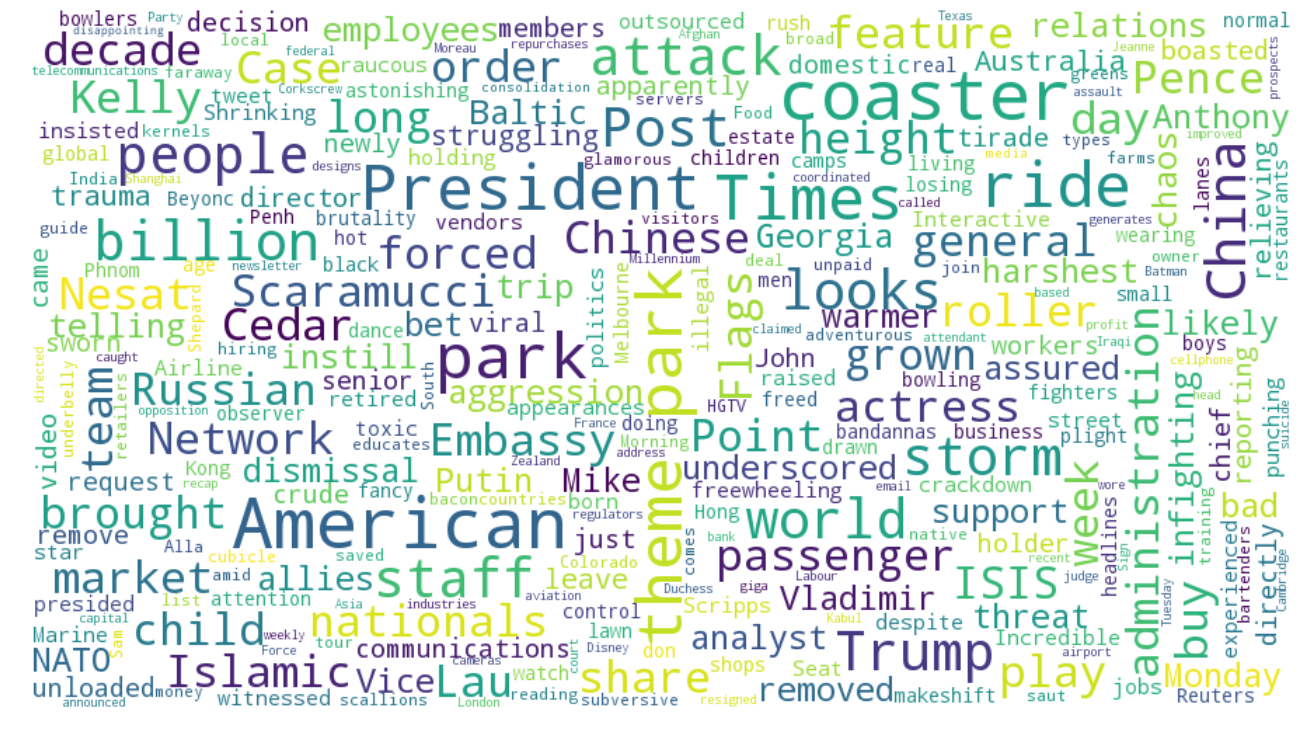

In [5258]:
# 108, 2435
plt.figure(figsize=(20,10),)
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.tight_layout(pad=0)
plt.show()